In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import geopandas as gpd
import itertools
from tqdm import tqdm

In [228]:
mindat = gpd.read_file(r'J:\Geology\WSGS\Projects\Critical Minerals\hotspot analysis\arcgis_blows.shp')
hucs = gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp')
hucs = hucs.to_crs(crs={'init': 'epsg:3732'})

In [300]:
hucs['FID'] = hucs.index.values
#hucs.to_file(driver='ESRI Shapefile', filename='huc_12_fids.shp')

In [303]:
keys = hucs.loc[0:].FID #huc basin number

In [304]:
ds=[]
for i in range(len(hucs)):
    downstream = hucs[hucs['HUC_12'] == hucs.loc[i].HU_12_DS].FID.values
    ds.append(downstream)
#huc basin downstream of huc basin

KeyError: 'the label [0] is not in the [index]'

In [305]:
us = []
for i in range(len(hucs)):
    upstream = hucs.loc[hucs['HU_12_DS'] == hucs.loc[i].HUC_12].FID.values
    us.append(upstream)

KeyError: 'the label [0] is not in the [index]'

In [306]:
lso = []
for i in range(len(ds)):
    ls = []
    if ds[i].size>0:
        ls.append(ds[i][0])
    else:
        ls.append(-1)
    for j in range(len(us[i])):
        if us[i].size>0:
            ls.append(us[i][j])
        else:
            ls.append(-1)
    lso.append(ls)

In [307]:
neighbors = dict(zip(keys, lso))

In [308]:
def GangsterRoll(element):
    Xbar = hucs[element].mean() #calculates the mean value of the element across all HUCS
    S = np.sqrt((((hucs[element])**2).sum()/len(hucs))-(Xbar**2)) #calculates the S value in the denominator
    import scipy.sparse as sp #import bruh
    mat = sp.dok_matrix((len(hucs), len(hucs)), dtype=np.int8) #creates a sparse matrix based on a dictionary of keys from above
    for huc_a, huc_b in neighbors.items(): #this creates a sparse matrix of spatial contiguity weights
        mat[huc_a, huc_b] = 1
        mat = mat.transpose().tocsr()
    z_score = []
    for i in tqdm(range(len(hucs))): #here is the G* function that calculates the z-score
        try:
            row_standardized = mat.toarray()[i]/mat.toarray()[i].sum()
            numerator = ((hucs[element].values*row_standardized).sum())-(row_standardized.sum()*Xbar) #numerator
            denominator = np.sqrt(abs(((row_standardized**2).sum())-(row_standardized.sum())**2)/(len(row_standardized)-1))*S #denominator
            z_score.append(numerator/denominator)
        except:
            z_score.append(np.nan)
    hucs['z_score'] = z_score
    hucs['z_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    hucs['z_score'].fillna(0, inplace=True)
    G = hucs[[element, 'HUC_12', 'z_score', 'geometry']]
    #G.to_file(driver='ESRI Shapefile', filename='./drainage hotspots/'+str(element)+'_hotspots.shp')
    G.plot(column='z_score', scheme='fisher_jenks')

  0%|                                                                                         | 0/2175 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
100%|████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:01<00:00, 1647.72it/s]


ValueError: Fewer unique values than specified classes.

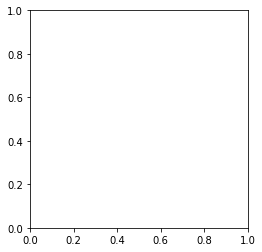

In [309]:
GangsterRoll('AREA')

In [10]:
element_list = hucs.columns[3:-30].values
for thing in element_list:
    GangsterRoll(thing)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
  0%|                                                                                         | 0/2175 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:14<00:00, 147.39it/s]


In [310]:
posi = dict(zip(keys, list(zip(hucs.centroid.x.values, hucs.centroid.y.values))))

In [311]:
import networkx as nx
G=nx.Graph()

In [312]:
G.add_nodes_from(hucs.FID.values)

In [313]:
edges = []
for i in range(len(keys)):
    val = list(filter(lambda a: a != -1, lso[i]))
    for j in range(len(val)):
        if np.sum(val)>0:
            edges.append((keys[i], val[j]))
        else:
            pass
    

IndexError: list index out of range

In [314]:
G.add_edges_from(edges)

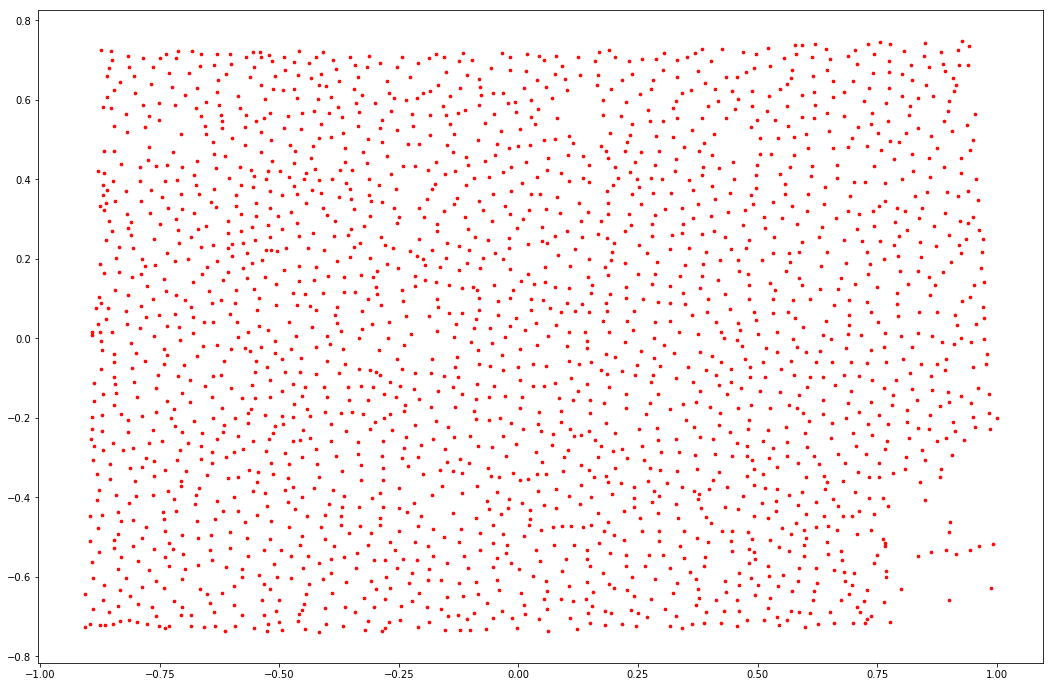

In [315]:
plt.figure(figsize=(18,12)) 
pos = nx.spring_layout(G,pos=posi)
nx.draw_networkx(G,pos, with_labels=False, node_size=7)

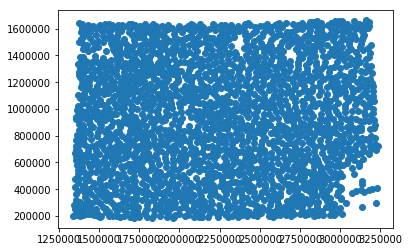

In [248]:
plt.scatter(mindat.centroid.x, mindat.centroid.y)

In [251]:
mindat[mindat['latitude'] == 44.4611]

,OBJECTID,Join_Count,TARGET_FID,u_dn_ppm,u_fl_ppm,ag_ppm,al_pct,as_ppm,au_ppm,b_ppm,...,HU_12_MOD,HU_12_TYPE,HU_2_NAME,HU_4_NAME,HU_6_NAME,HU_8_NAME,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,1,6,0,18.4,24.85,6.0,6.721,10713.0,0.0,67.0,...,NM,S,Missouri,Missouri Headwaters,Missouri Headwaters,Madison,0.94862,219025.386275,0.021609,"POLYGON ((1448025.078820918 1450822.594227672,..."


In [272]:
m2 = mindat.iloc[:,3:54]
m2['geometry'] = mindat.centroid

In [293]:
comb = gpd.sjoin(hucs, m2, how='inner')

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


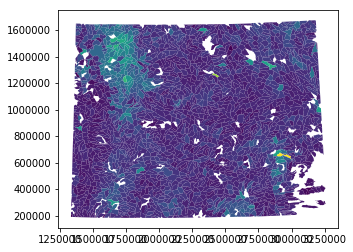

In [294]:
comb.plot(column='co_ppm')

In [295]:
hucs = comb

In [299]:
hucs

,AREA,PERIMETER,WY_HU12_,WY_HU12_ID,HUC_8,HUC_10,HUC_12,ACRES,STATES,NCONTRB_A,...,ta_ppm,tb_ppm,th_ppm,ti_ppm,v_ppm,w_ppm,y_ppm,yb_ppm,zn_ppm,zr_ppm
1,0.018025,0.729417,154,25,10070001,1007000107,100700010708,38981.817764,"MT,WY",0.0,...,2.0,0.0,13.6,3857.0,97.0,4.0,16.0,3.7,105.0,270.0
5,0.018245,0.845132,162,54,10070006,1007000601,100700060101,39468.562797,"MT,WY",0.0,...,0.0,0.0,10.2,5544.0,202.0,14.0,22.0,3.0,119.0,257.0
9,0.010382,0.633671,175,100,10090208,1009020805,100902080508,22457.865524,"MT,WY",0.0,...,0.0,0.0,9.0,2744.0,66.0,1.0,16.0,1.9,36.0,64.0
12,0.015275,0.915921,179,101,10090208,1009020805,100902080506,33052.576433,"MT,WY",0.0,...,0.0,0.0,11.6,3391.0,113.0,8.0,18.0,3.9,95.0,52.0
13,0.010354,0.684346,182,103,10090207,1009020702,100902070203,22407.748745,"MT,WY",0.0,...,0.0,0.0,10.1,3328.0,86.0,4.0,6.0,3.4,81.0,68.0
14,0.017239,0.943386,185,72,10080014,1008001405,100800140502,37343.638037,"MT,WY",0.0,...,0.0,0.0,8.6,6294.0,228.0,12.0,23.0,2.9,23.0,280.0
14,0.017239,0.943386,185,72,10080014,1008001405,100800140502,37343.638037,"MT,WY",0.0,...,0.0,0.0,13.6,3225.0,74.0,13.0,40.0,4.9,111.0,533.0
15,0.010349,0.756511,186,64,10070006,1007000601,100700060104,22389.981813,"MT,WY",0.0,...,1.0,1.0,29.1,3989.0,124.0,7.0,36.0,4.5,19.0,308.0
16,0.018704,0.780425,188,99,10090101,1009010103,100901010303,40470.883757,"MT,WY",0.0,...,0.0,0.0,0.0,2567.0,50.0,8.0,4.0,3.3,5.0,64.0
17,0.019898,0.821057,190,108,10110201,1011020104,101102010402,43050.998729,"MT,WY",0.0,...,1.0,1.0,11.1,3863.0,163.0,12.0,13.0,3.0,145.0,135.0
